In [77]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
import zipfile
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, LSTM, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
zip_path = '/content/file.zip'  # <-- Change this to your actual uploaded zip file path  # or any desired path
extract_path = '/content/extracted_files' # <-- Change this to your desired extraction path
os.makedirs(extract_path, exist_ok=True) # Create the extraction directory if it doesn't exist
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
paths = []
labels = []

for root, _, files in os.walk(extract_path):
    for file in files:
        if file.endswith('.wav'):
            full_path = os.path.join(root, file)
            paths.append(full_path)

            # Extract emotion from parent directory (e.g., OAF_angry → angry)
            label = os.path.basename(root).split('_')[-1]
            labels.append(label.lower())

            if len(paths) == 2800:
                break
    if len(paths) == 2800:
        break


In [ ]:
df = pd.DataFrame({
    'speech': paths,
    'label': labels
})

df.head(5)

,speech,label
0,/content/extracted_files/TESS Toronto emotiona...,sad
1,/content/extracted_files/TESS Toronto emotiona...,sad
2,/content/extracted_files/TESS Toronto emotiona...,sad
3,/content/extracted_files/TESS Toronto emotiona...,sad
4,/content/extracted_files/TESS Toronto emotiona...,sad


In [73]:
df['label'].value_counts()

,count
label,
sad,400
happy,400
fear,400
neutral,400
angry,400
disgust,400
surprised,200
surprise,200


In [ ]:
df['label'] = df['label'].replace('surprised', 'surprise')

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

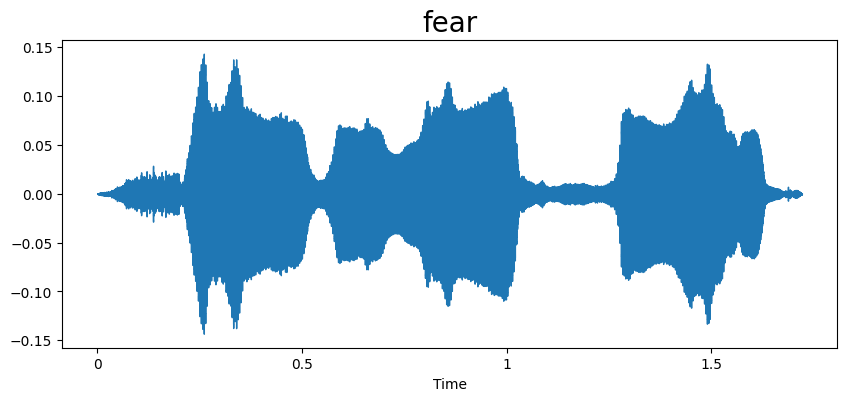

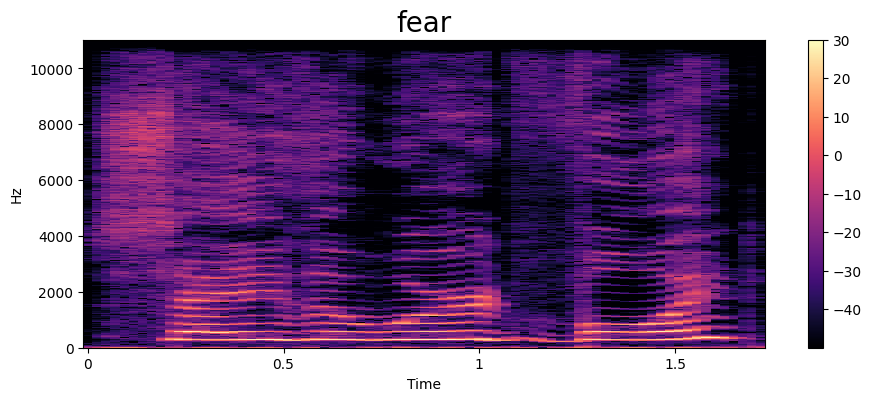

In [ ]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

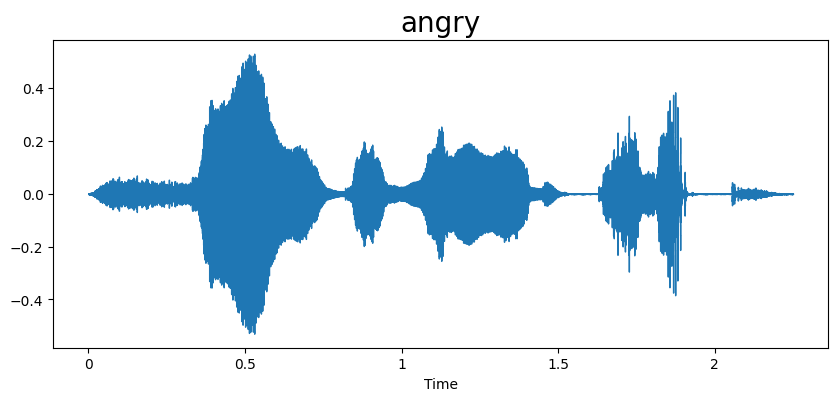

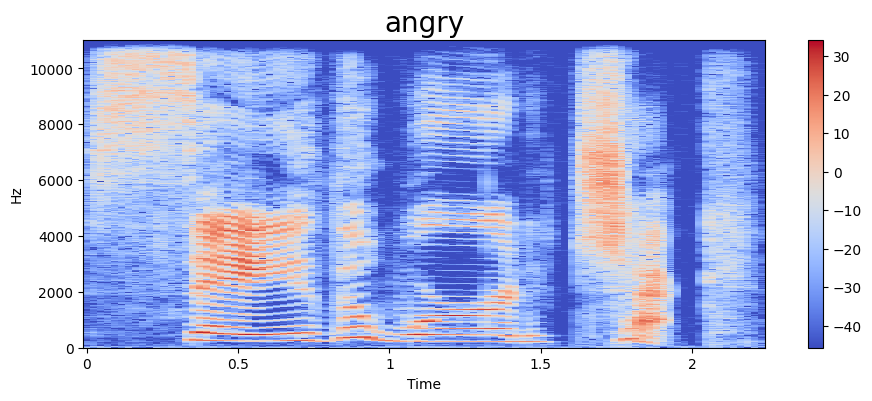

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

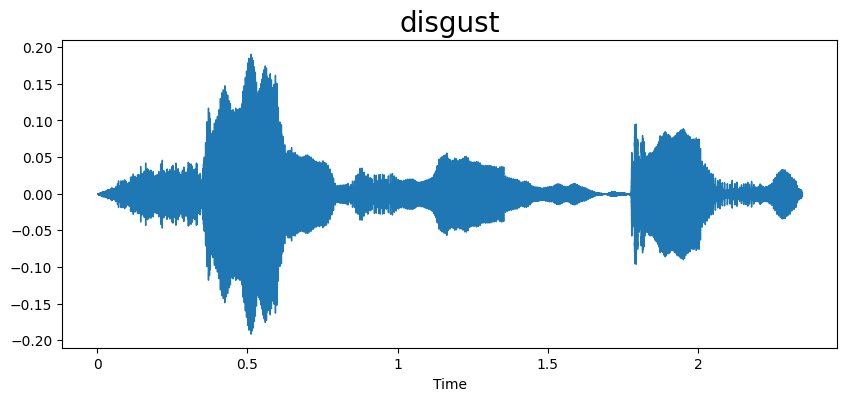

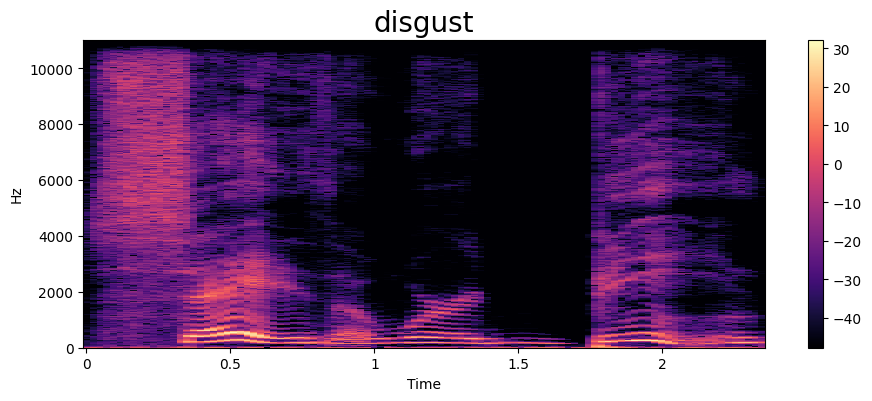

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

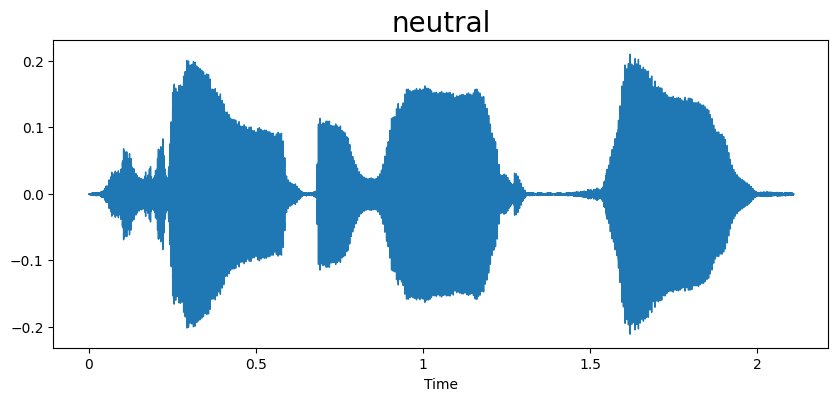

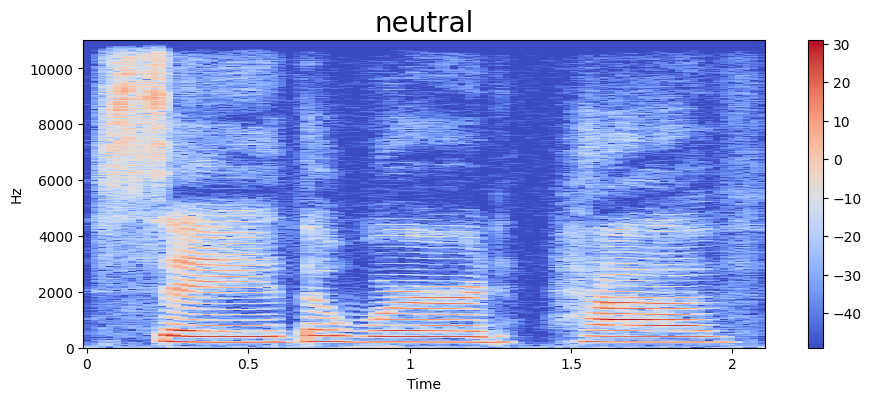

In [ ]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def extract_features(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)

    # 1. MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

    # 2. Chroma
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)

    # 3. Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)

    # 4. Spectral Contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)

    # 5. Tonnetz (tonal centroid features)
    y_harmonic = librosa.effects.harmonic(y)
    tonnetz = np.mean(librosa.feature.tonnetz(y=y_harmonic, sr=sr).T, axis=0)

    # Concatenate all features
    combined_features = np.hstack([mfcc, chroma, mel, contrast, tonnetz])
    return combined_features

In [ ]:
X = []
for path in df['speech']:
    features = extract_features(path)
    X.append(features)

In [ ]:
X = np.array(X)
print(X.shape)

(2800, 193, 1)


In [ ]:
X = np.expand_dims(X, -1)
X.shape

(2800, 193, 1, 1)

In [ ]:
y = df['label'].values

In [ ]:
y = np.array(y).reshape(-1, 1)
ohe = OneHotEncoder(sparse_output=False)
y_enco = ohe.fit_transform(y)

In [ ]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(193, 1)),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(LSTM(64)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(7, activation='softmax')  # 7 emotion classes
])


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.build()

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 193, 256)       │       133,120 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 193, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 193, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,719 (1.17 MB)

 Trainable params: 306,951 (1.17 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
original_indices = np.arange(len(X))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y_enco, original_indices, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 642ms/step - accuracy: 0.1794 - loss: 2.2493 - val_accuracy: 0.3881 - val_loss: 1.6595
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 629ms/step - accuracy: 0.3866 - loss: 1.5627 - val_accuracy: 0.6774 - val_loss: 1.1388
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 622ms/step - accuracy: 0.6053 - loss: 1.0698 - val_accuracy: 0.7845 - val_loss: 0.5922
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 620ms/step - accuracy: 0.8127 - loss: 0.5507 - val_accuracy: 0.9238 - val_loss: 0.2595
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 612ms/step - accuracy: 0.8853 - loss: 0.3615 - val_accuracy: 0.9583 - val_loss: 0.1545
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 623ms/step - accuracy: 0.9351 - loss: 0.2329 - val_accuracy: 0.9690 - val_loss: 0.1116
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 628ms/step - accuracy: 0.9386 - loss: 0.2402 - val_accuracy: 0.9702 - val_loss: 0.1047
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 629ms/step - accuracy: 0.9459 - loss: 0.2020 - val_accu

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9648 - loss: 0.0952


In [ ]:
sample_to_predict = X_test[490]

# Remove the extra dimension if needed
sample_to_predict = sample_to_predict.squeeze()

# Reshape to match model input
sample_to_predict = sample_to_predict.reshape(1, 193, 1)

# Make the prediction
prediction = model.predict(sample_to_predict)

# Convert to one-hot encoding
predicted_class = np.argmax(prediction)
one_hot_result = np.zeros(prediction.shape[1])
one_hot_result[predicted_class] = 1

# Print the one-hot encoded prediction
print(one_hot_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
[0. 0. 0. 0. 0. 0. 1.]


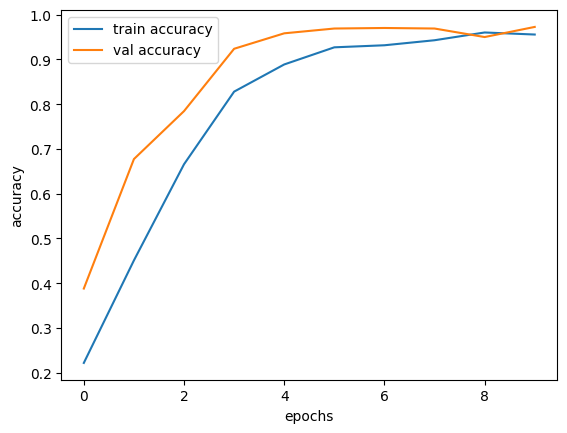

In [74]:
epochs = history.epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# EVALUATION

In [70]:
a = []
features = extract_features("/content/YAF_vine_fear.wav")
a.append(features)

In [71]:
a = np.array(a)

In [72]:
sample_to_predict = a.squeeze()

# Reshape to match model input
sample_to_predict = sample_to_predict.reshape(1, 193, 1)

# Make the prediction
prediction = model.predict(sample_to_predict)

# Convert to one-hot encoding
predicted_class = np.argmax(prediction)
one_hot_result = np.zeros(prediction.shape[1])
one_hot_result[predicted_class] = 1

# Print the one-hot encoded prediction
print(one_hot_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[0. 0. 1. 0. 0. 0. 0.]
